In [2]:
import os
import pandas as pd
import torch
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('../../data/lens_tmdb/ratings_small.csv')
df['userId'] = df['userId'].astype('category').cat.codes
df['movieId'] = df['movieId'].astype('category').cat.codes + df['userId'].nunique()

# Create a graph
edge_index = torch.tensor(df[['userId', 'movieId']].values, dtype=torch.long).t().contiguous()
x = torch.ones(df['userId'].nunique() + df['movieId'].nunique(), 1)

# Split the data into training and test sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Create graph data for training and test sets
train_data = Data(x=x, edge_index=torch.tensor(train_df[['userId', 'movieId']].values, dtype=torch.long).t().contiguous(), y=torch.tensor(train_df['rating'].values, dtype=torch.float))
test_data = Data(x=x, edge_index=torch.tensor(test_df[['userId', 'movieId']].values, dtype=torch.long).t().contiguous(), y=torch.tensor(test_df['rating'].values, dtype=torch.float))


In [3]:
# Define the GNN model
class GNNRecommendation(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GNNRecommendation, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = torch.nn.Linear(hidden_channels, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.out(x)
        return x.view(-1)

In [4]:
# Additional evaluation metrics

# RMSE function
def rmse(predictions, targets):
    return torch.sqrt(((predictions - targets) ** 2).mean())


def mae(predictions, targets):
    return torch.abs(predictions - targets).mean()

def mse(predictions, targets):
    return ((predictions - targets) ** 2).mean()

# Evaluation function
def evaluate(data):
    model.eval()
    with torch.no_grad():
        predictions = model(data)[data.edge_index[0]]
        loss_mse = mse(predictions, data.y)
        rmse_value = rmse(predictions, data.y).item()
        mae_value = mae(predictions, data.y).item()
    return loss_mse.item(), rmse_value, mae_value

In [6]:
# Training function
def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.edge_index[0]], data.y)
    loss.backward()
    optimizer.step()
    return loss.item()


# Initialize the model, criterion, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNNRecommendation(1, 16).to(device)
train_data = train_data.to(device)
test_data = test_data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

In [8]:
# Training loop
epochs = 20
train_losses = []
test_losses = []
train_rmses = []
test_rmses = []
train_maes = []
test_maes = []
train_mses = []  # Store MSE for training data
test_mses = []

for epoch in range(epochs):
    train_loss = train(train_data)
    test_loss, test_rmse, test_mae = evaluate(test_data)
    train_rmse_value = train(train_data)
    train_mae_value = mae(model(train_data)[train_data.edge_index[0]], train_data.y).item()
    train_mse_value = mse(model(train_data)[train_data.edge_index[0]], train_data.y).item()  # Compute MSE for training data

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_rmses.append(train_rmse_value)
    test_rmses.append(test_rmse)
    train_maes.append(train_mae_value)
    test_maes.append(test_mae)
    train_mses.append(train_mse_value)  # Append MSE for training data
    test_mses.append(test_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train RMSE: {train_rmse_value:.4f}, Test RMSE: {test_rmse:.4f}, Train MAE: {train_mae_value:.4f}, Test MAE: {test_mae:.4f}, Train MSE: {train_mse_value:.4f}, Test MSE: {test_loss:.4f}")

Epoch 1/20, Train Loss: 13.2345, Test Loss: 12.9012, Train RMSE: 12.9107, Test RMSE: 3.5918, Train MAE: 3.3840, Test MAE: 3.4318, Train MSE: 12.4182, Test MSE: 12.9012
Epoch 2/20, Train Loss: 12.5487, Test Loss: 12.0492, Train RMSE: 12.1054, Test RMSE: 3.4712, Train MAE: 3.2334, Test MAE: 3.3054, Train MSE: 11.6274, Test MSE: 12.0492
Epoch 3/20, Train Loss: 11.4245, Test Loss: 11.1789, Train RMSE: 11.2132, Test RMSE: 3.3435, Train MAE: 3.0699, Test MAE: 3.1710, Train MSE: 10.8654, Test MSE: 11.1789
Epoch 4/20, Train Loss: 10.8692, Test Loss: 10.2255, Train RMSE: 10.2486, Test RMSE: 3.1977, Train MAE: 2.9310, Test MAE: 3.0177, Train MSE: 9.9046, Test MSE: 10.2255
Epoch 5/20, Train Loss: 10.0757, Test Loss: 9.1364, Train RMSE: 9.1640, Test RMSE: 3.0227, Train MAE: 2.7492, Test MAE: 2.8355, Train MSE: 8.5996, Test MSE: 9.1364
Epoch 6/20, Train Loss: 8.8812, Test Loss: 7.9162, Train RMSE: 8.1696, Test RMSE: 2.8136, Train MAE: 2.5392, Test MAE: 2.6160, Train MSE: 7.9164, Test MSE: 7.9162
Ep

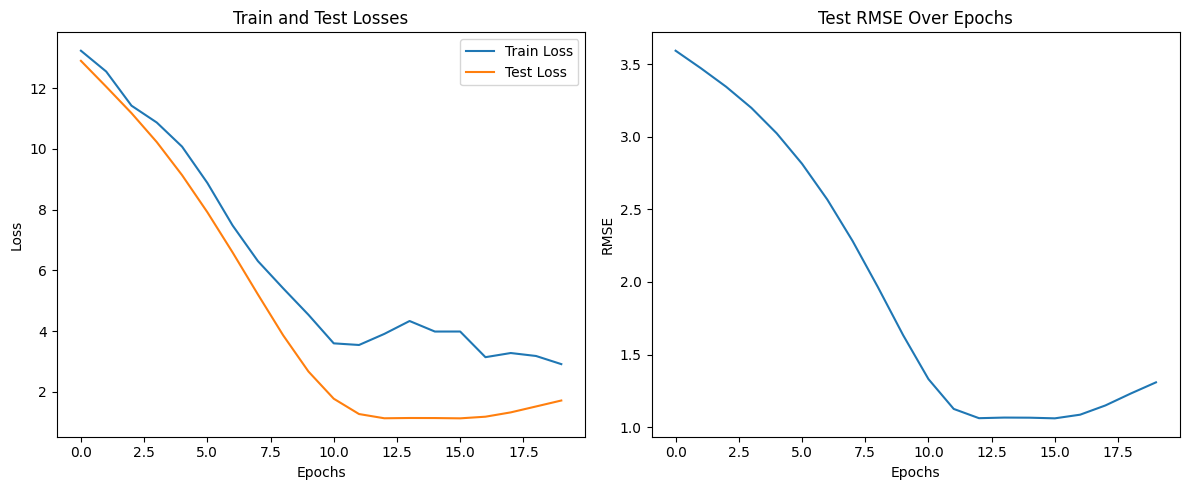

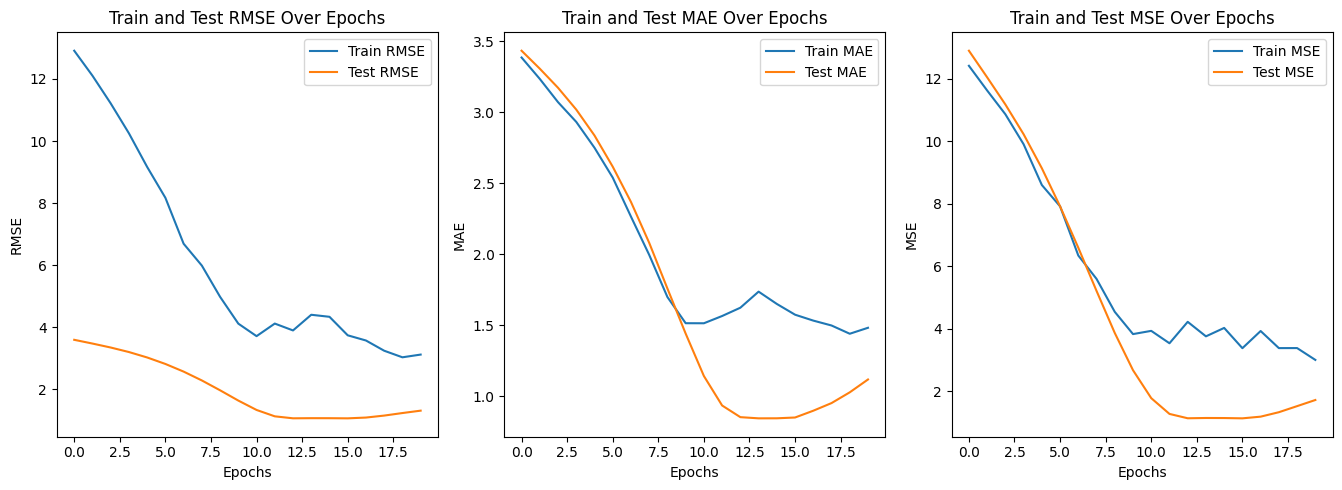

In [9]:
# Visualization
plt.figure(figsize=(12, 5))

# Plotting training and test losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Test Losses')

# Plotting RMSE
plt.subplot(1, 2, 2)
plt.plot(test_rmses)
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Test RMSE Over Epochs')

plt.tight_layout()
plt.show()

# Visualization
plt.figure(figsize=(18, 5))

# Plotting RMSE for training and test data
plt.subplot(1, 4, 1)
plt.plot(train_rmses, label='Train RMSE')
plt.plot(test_rmses, label='Test RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title('Train and Test RMSE Over Epochs')

# Plotting MAE for training and test data
plt.subplot(1, 4, 2)
plt.plot(train_maes, label='Train MAE')
plt.plot(test_maes, label='Test MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Train and Test MAE Over Epochs')

# Plotting MSE (Loss) for training and test data
plt.subplot(1, 4, 3)
plt.plot(train_mses, label='Train MSE')
plt.plot(test_mses, label='Test MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.title('Train and Test MSE Over Epochs')

plt.tight_layout()
plt.show()